# ARAR Model


The **ARAR** algorithm is a specialized time-series forecasting method designed to handle data with **long-memory components** or **complex trends**. Unlike traditional models that rely on rigid structures to stationarize data, ARAR employs a dynamic, two-step process: transforming the data through **memory shortening** and then modeling the remaining signal. This approach allows ARAR to be **fully automated**, making it a powerful alternative for scenarios where manual model selection is impractical.

The ARAR algorithm is defined by its unique workflow, which separates the **data transformation** process from the **prediction** process.

**Phase 1: The Memory Shortening Process**

Before any forecasting occurs, ARAR applies a series of **adaptive filters** to the raw data.

* **Goal:** To decorrelate the data and remove **long-term dependencies** (trends and seasonality) that confuse standard models.
* **Method:** It uses **memory-shortening filters**. Rather than just looking at the immediately preceding time step, these filters can subtract a fraction of a value from a longer lag (e.g., a week or a year ago).
* **Result:** Transformed data that is **short-memory**, making it easier to predict using simple autoregressive rules.

**Phase 2: Fitting the Model**

Once the data has been transformed, the algorithm fits a standard model to the residuals.

* **Model Type:** It utilizes an **AR (Autoregressive)** model.
* **Simplicity:** Because Phase 1 does the heavy lifting of removing complex patterns, Phase 2 only needs to look at past values (an "all-pole" model) rather than modeling random shocks (Moving Averages).

**ARAR vs. ARIMA**

While both methods aim to predict future values based on history, they approach the problem from fundamentally different angles.

| Feature | ARIMA (Auto-Regressive Integrated Moving Average) | ARAR (Memory Shortening + AR) |
| :--- | :--- | :--- |
| **Transformation** | **Fixed Differencing.** It removes trends by computing $y_t - y_{t-1}$ (the "Integration" step). | **Adaptive Filters.** It uses memory-shortening filters to subtract fractions of values from various time lags. |
| **Model Form** | **ARMA.** It fits a combination of Autoregressive (AR) and Moving Average (MA) terms. | **AR Only.** It fits a pure Autoregressive model to the transformed data. |
| **Automation** | **Configurable.** Requires selecting orders ($p, d, q$), though auto-selection methods (AIC, BIC) can assist. | **Fully Automated.** Designed to run with minimal human intervention, making it ideal for bulk processing. |


<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:600;">
  <span style="margin-right:6px; font-size:22px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0; color:inherit;">
  
The Python implementation of the ARAR algorithm in skforecast is based on the Julia package <a href="https://taf-society.github.io/Durbyn.jl/dev/">Durbyn.jl</a> developed by Resul Akay. For more details on the mathematical formulation and estimation procedures, visit the <a href="https://cienciadedatos.net/documentos/py73-arar-forecasting-models-python">ARAR Forecasting Models in Python</a>.
</p>

</div>

## Libraries and data

In [ ]:
# Libraries
# ==============================================================================
import sys
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.stats import Arar
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme, plot_prediction_intervals
from skforecast.utils import expand_index
from sklearn.metrics import mean_absolute_error
set_dark_theme()

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=False)
data = data.loc[:'1990-01-01 00:00:00', ['Gasolinas']]
data = data.rename(columns={'Gasolinas': 'y'})
data.index.name = 'datetime'
data.head(4)

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 5 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

,y
datetime,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164


Train dates : 1969-01-01 00:00:00 --- 1983-01-01 00:00:00  (n=169)
Test dates  : 1983-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=84)


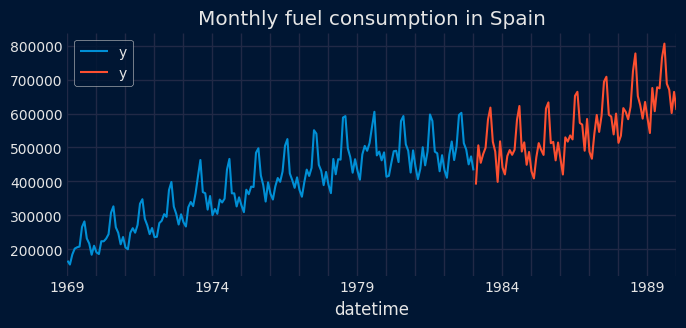

In [ ]:
# Split data in train-test partitions
# ======================================================================================
end_train = '1983-01-01 23:59:59'

print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

## ARAR

**Skforecast** provides the class [`ARAR`](../api/stats.html#skforecast.stats._arar.Arar) to facilitate the creation of ARAR models in Python, allowing users to easily **fit** and **forecast** time series data using this approach.

Two arguments can be specified when creating an instance of the `ARAR` class:

+ `max_ar_depth`: **Maximum lag** considered when fitting the **subset autoregressive model**. If not specified, defaults are data-dependent: 26 for series with >40 observations, 13 for series with 13-40 observations, or `max(4, ⌈n/3⌉)` for shorter series.

+ `max_lag`: **Maximum lag** used when computing **autocovariances**. If not specified, defaults are data-dependent: 40 for series with >40 observations, 13 for series with 13-40 observations, or `max(4, ⌈n/2⌉)` for shorter series.

In [4]:
# ARAR model
# ==============================================================================
model = Arar()
model.fit(y=data_train['y'])

,max_ar_depth,26
,max_lag,40
,safe,True


In [5]:
# Show model summary
# ==============================================================================
model.summary()

Arar(lags=(1, 2, 12, 13)) Model Summary
------------------
Selected AR lags:                         (1, 2, 12, 13)
AR coefficients (phi):                    [ 0.3206  0.4527 -0.3356  0.2754]
Residual variance (sigma^2):              342660159.5155
Mean of shortened series (sbar):          3967.4370
Length of memory-shortening filter (psi): 13

Time Series Summary Statistics
Number of observations: 169
Mean:                   384743.1773
Std Dev:                108126.6689
Min:                    155466.8105
25%:                    303667.7591
Median:                 397278.0241
75%:                    466194.3073
Max:                    605073.0143

Model Diagnostics
AIC: 3255.5717
BIC: 3273.3906


## Prediction

Once the model is fitted, it can be used to **forecast future observations**. It is important to note that these types of models require predictions to **follow immediately after the training data**; therefore, the forecast starts right after the **last observed value**.

In [6]:
# Prediction
# ==============================================================================
steps = len(data_test)
predictions = model.predict(steps=steps)

For performance reasons, predictions are returned as **NumPy arrays**. These can be easily converted into **Pandas Series** by mapping them to the corresponding **time index**.

In [7]:
# Predictions as pandas Series
# ==============================================================================
pred_index = expand_index(index=data_train.index, steps=steps)
predictions = pd.Series(predictions, index=pred_index)
predictions.head(4)

1983-02-01    409292.695102
1983-03-01    474934.656818
1983-04-01    533164.639570
1983-05-01    471306.389878
Freq: MS, dtype: float64

In [8]:
# Prediction error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mae): {error_mae}")

Test error (mae): 46939.1113853454


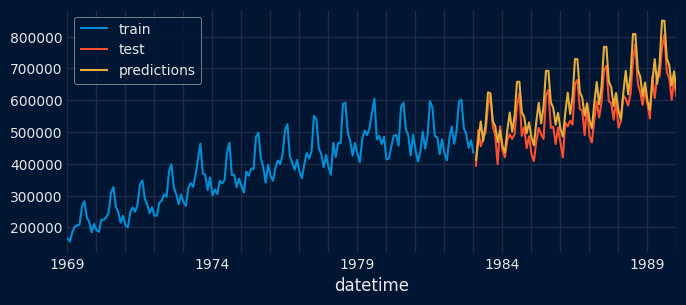

In [9]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Prediction intervals

The method `predict_interval` enables the calculation of **prediction intervals** for the forecasted values. Users can specify the **confidence level** of the estimated interval using the `level` argument.

In [10]:
# Prediction interval
# ==============================================================================
predictions = model.predict_interval(steps=steps, level=[95])
predictions.index = pred_index
predictions.head(3)

,mean,lower_95,upper_95
1983-02-01,409292.695102,373011.640924,445573.749280
1983-03-01,474934.656818,436834.085425,513035.228212
1983-04-01,533164.639570,490061.171827,576268.107312


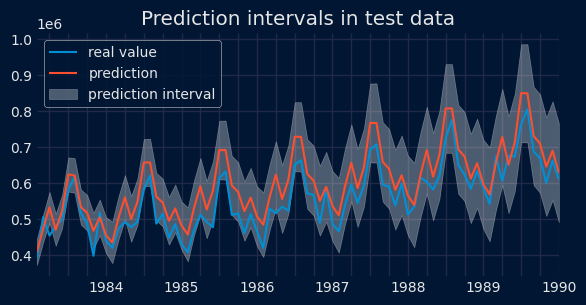

In [11]:
# Plot prediction intervals
# ==============================================================================
preds_to_plot = predictions.copy()
preds_to_plot = preds_to_plot.rename(
    columns={'mean': 'pred', 'lower_95': 'lower_bound', 'upper_95': 'upper_bound'}
)

fig, ax = plt.subplots(figsize=(6, 3))
plot_prediction_intervals(
    predictions         = preds_to_plot,
    y_true              = data_test,
    target_variable     = "y",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'white', 'alpha': 0.3, 'zorder': 1},
    ax                  = ax
)

## Feature importances

The method `get_feature_importances` returns the **AR coefficients** of the fitted subset autoregressive model, indicating the weight assigned to each lag term.

In [12]:
# Feature importances
# ==============================================================================
model.get_feature_importances()

,feature,importance
0,lag_1,0.320650
1,lag_2,0.452729
2,lag_12,-0.335571
3,lag_13,0.275434


## Exogenous variables

When **exogenous variables** are provided during fitting, the model uses a
**two-step approach** (linear regression followed by ARAR on residuals). In this
approach, the target series is first regressed on the exogenous variables
using a **linear regression model**. The **residuals** from this regression,
representing the portion of the series not explained by the exogenous
variables, are then modeled using the **ARAR model**.

$$
y_t =
\underbrace{\text{linear effect of exogenous variables}}_{\text{regression}}
+
\underbrace{\text{structured residual dynamics}}_{\text{ARAR}}
+
\varepsilon_t
$$

This design allows the influence of exogenous variables to be incorporated
prior to applying the ARAR model, rather than within the ARAR dynamics
themselves.

This two-step approach is necessary because the ARAR model is inherently
univariate and does not natively support exogenous variables. By separating
the regression step, the method preserves the original ARAR formulation
while still capturing the effects of external predictors.

However, this approach carries important **assumptions and implications**:

- The relationship between the target series and the exogenous variables is
assumed to be **linear** and **time-invariant**.
- The ARAR model is applied only to the **residual process**, meaning its
parameters describe the dynamics of the series after removing the
contribution of exogenous variables.
- As a result, the **interpretability** of the ARAR parameters changes: they no
longer describe the full data-generating process, but rather the behavior
of the **unexplained component**.

Despite these limitations, this strategy provides a practical and
computationally efficient way to incorporate exogenous information into an
otherwise univariate ARAR framework.

Use this two-step regression + ARAR approach when the exogenous variables
have a **clear linear effect** on the target, the residual series exhibits
**autocorrelation** that ARAR can model, and the relationship between covariates
and the target is **relatively stable over time**. This method is most effective
when you want to preserve the simplicity and efficiency of ARAR while
incorporating external information. **Avoid this approach** if covariate effects
are **strongly nonlinear**, **time-varying**, or interact with **seasonal/trend
patterns**, as the residual modeling may then be inadequate.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about exogenous variables and how to correctly manage them with skforecast visit: <a href="../user_guides/exogenous-variables.html">Exogenous variables (features) user guide</a>.

</div>

In [13]:
# Create calendar features to be used as exogenous variables
# ==============================================================================
data_exog = data.assign(month=data.index.month)
data_exog_train = data_exog.loc[:end_train]
data_exog_test  = data_exog.loc[end_train:]
data_exog.head()

,y,month
datetime,,
1969-01-01,166875.2129,1
1969-02-01,155466.8105,2
1969-03-01,184983.6699,3
1969-04-01,202319.8164,4
1969-05-01,206259.1523,5


In [14]:
# Create and fit model with exogenous variables
# ==============================================================================
model = Arar()
model.fit(y= data_exog_train['y'], exog=data_exog_train['month'])

# Predict with exog
# ==============================================================================
predictions = model.predict(steps=steps, exog=data_exog_test['month'])
pred_index = expand_index(index=data_train.index, steps=steps)
predictions = pd.Series(predictions, index=pred_index)
predictions.head(3)

╭─────────────────────────── ExogenousInterpretationWarning ───────────────────────────╮
│ Exogenous variables are being handled using a two-step approach: (1) linear          │
│ regression on exog, (2) ARAR on residuals. This affects model interpretation:        │
│   - ARAR coefficients (coef_) describe residual dynamics, not the original series    │
│   - Pred intervals reflect only ARAR uncertainty, not exog regression uncertainty    │
│   - Assumes a linear, time-invariant relationship between exog and target            │
│ For more details, see the fit() method's Notes section of ARAR class.                │
│                                                                                      │
│ Category : skforecast.exceptions.ExogenousInterpretationWarning                      │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\skforecast\stats\_ │
│ arar.py:293                                                                          │
│ Suppress : warnings.simplefilter('ignore', category=ExogenousInterpretationWarning)  │
╰──────────────────────────────────────────────────────────────────────────────────────╯

1983-02-01    416116.376094
1983-03-01    458723.374725
1983-04-01    489896.792806
Freq: MS, dtype: float64

## Backtesting

In time series forecasting, the process of [backtesting](./backtesting.html) consists of **evaluating the performance** of a predictive model by applying it **retrospectively to historical data**. To utilize the backtesting functionalities offered by skforecast with ARAR models, the model must be used as an **estimator** within a [`ForecasterStats`](./forecasting-statistical-models.html) object.

<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:400;">
  <span style="margin-right:6px; font-size:18px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0 ; color:inherit;">
<b>Why do statistical models require refitting during backtesting?</b>
</p>

<p>
Unlike machine learning models, statistical models like ARAR maintain an internal state that depends on the sequence of observations. They can only generate predictions starting from the last observed time step — they cannot "jump" to an arbitrary point in the future without knowing all previous values.

During backtesting, when the validation window moves forward, the model must be refitted to incorporate the new observations and update its internal state. This is why <code>refit=True</code> is typically required.

<b>Performance optimization:</b> Because refitting is mandatory, skforecast's Numba-optimized backend becomes essential. It enables hundreds of refits during backtesting in a fraction of the time required by non-optimized libraries.
</p>

</div>

In [15]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterStats(estimator=Arar())
forecaster

=============== 
ForecasterStats 
=============== 
Estimators: ['skforecast.Arar'] 
Series name: None 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Estimator parameters: 
    skforecast.Arar: {'max_ar_depth': None, 'max_lag': None, 'safe': True} 
fit_kwargs: None 
Creation date: 2026-01-31 20:24:44 
Last fit date: None 
Index seen by the forecaster: None 
Skforecast version: 0.20.0 
Python version: 3.12.11 
Forecaster id: None

In [16]:
# Backtest forecaster
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 12,  # predict 12 month per fold
         initial_train_size = len(data_train),
         refit              = True,
         fixed_train_size   = False,
     )

metric, predictions = backtesting_stats(
                          forecaster        = forecaster,
                          y                 = data['y'],
                          cv                = cv,
                          metric            = 'mean_absolute_error',
                          n_jobs            = 'auto',
                          suppress_warnings = True,
                          verbose           = True,
                          show_progress     = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 169
Number of observations used for backtesting: 84
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02-01 00:00:00 -- 1985-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1985-01-01 00:00:00  (n=193)
    Validation: 1985-02-01 00:00:00 -- 1986-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1986-01-01 00:00:00  (n=205)
    Validation: 1986-02-01 00:00:00 -- 1987-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1987-01-01 00:00:00  (n=217)
    Validation: 1987-02-0

  0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
# Backtesting predictions
# ==============================================================================
predictions.head(3)

,fold,pred
1983-02-01,0,409292.695102
1983-03-01,0,474934.656818
1983-04-01,0,533164.639570


In [18]:
# Backtesting metrics
# ==============================================================================
metric

,mean_absolute_error
0,21270.947466


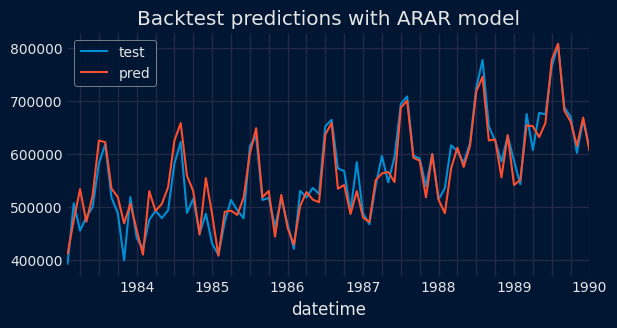

In [19]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax)
ax.set_title('Backtest predictions with ARAR model')
ax.legend();

## Memory optimization

For **production environments** where you need to store many fitted models but only require **forecasting capabilities** (not diagnostics), you can significantly **reduce memory usage** with the `reduce_memory()` method. This is especially useful when working with **large datasets** or deploying models in **resource-constrained environments**. This method removes **in-sample fitted values** and **residuals**, which are only needed for diagnostic purposes but not for generating forecasts.

In [20]:
# Compare size before and after reduce_memory()
# ==============================================================================
def total_model_size(model):
    size = sys.getsizeof(model)
    for attr_name in dir(model):
        if attr_name.startswith('_'):
            continue
        try:
            attr = getattr(model, attr_name)
            size += sys.getsizeof(attr)
        except Exception:
            pass
    return size


model = Arar()
model.fit(y=data_train['y'])
model_size_before = total_model_size(model)
print(f"Memory before reduce_memory(): {model_size_before / 1024:.3f} KB")

# Reduce memory
model.reduce_memory()
model_size_after = total_model_size(model)
print(f"Memory after reduce_memory(): {model_size_after / 1024:.3f} KB")
print(f"Memory reduction: {(1 - model_size_after / model_size_before) * 100:.1f}%")

Memory before reduce_memory(): 5.123 KB
Memory after reduce_memory(): 2.295 KB
Memory reduction: 55.2%


In [21]:
# Predictions still work after memory reduction
# ==============================================================================
model.predict(steps=10)

array([409292.69510231, 474934.65681833, 533164.63956981, 471306.38987833,
       521540.20231166, 624704.82153381, 621950.46146758, 534146.97012364,
       518085.06631994, 468517.6939802 ])